Layer 0: PyTorch Tensor, Shape = (100, 50, 1)
Showing data
Layer 0: PyTorch Tensor, Shape = (100, 50, 1)
Showing latent
Layer 0: PyTorch Tensor, Shape = (100, 50, 1)
Showing high level latent


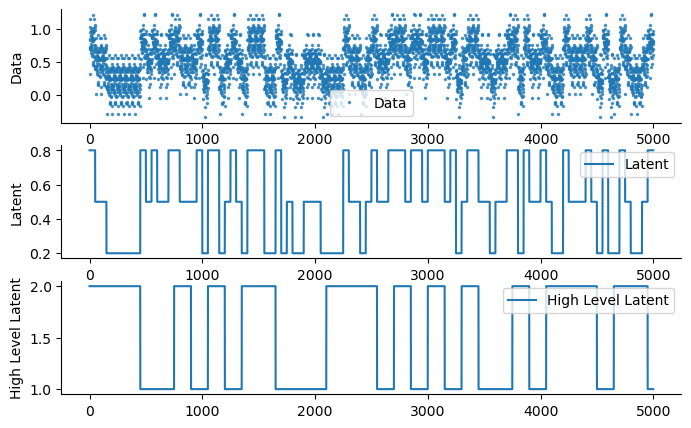

In [1]:
''' This file will focus on optimizing one latent for an entire sequence'''
import torch
from torch.utils.data import Dataset, DataLoader   
import torch.nn as nn

import numpy as np
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.cluster.hierarchy import dendrogram, linkage

# sns.set(style='white', palette='colorblind', context='talk')
# cpal = sns.color_palette('colorblind')

from torch.utils.data import Dataset, DataLoader
import numpy as np


def explore_data_container(data):
    """
    Explores a nested data container (list, numpy array, or PyTorch tensor).
    Args:
        data: The input data container.
    Returns:
        None
    """
    def print_info(layer, depth):
        if isinstance(layer, list):
            print(f"Layer {depth}: List, Length = {len(layer)}")
            for item in layer:
                print_info(item, depth + 1)
                break  # Only print the first item
        elif isinstance(layer, np.ndarray):
            print(f"Layer {depth}: Numpy Array, Shape = {layer.shape}")
        elif isinstance(layer, torch.Tensor):
            print(f"Layer {depth}: PyTorch Tensor, Shape = {tuple(layer.shape)}")
            return  # Stop exploring when a tensor is encountered
        else:
            print(f"Layer {depth}: Unknown type")
    print_info(data, depth=0)

class Config:
    def __init__(self):
        self.input_size = 1 # gets updated below
        self.hidden_size = 32
        self.output_size = 1
        self.seq_len = 50
        self.stride = self.seq_len
        self.WU_lr = 0.001
        self.batch_size = 100
        self.no_of_frames_to_prompt_generate = 10
        self.predict_first_frame = True

        # latent
        self.LU_lr = 0.01
        self.latent_type = '1d_latent'
        self.latent_dims = [10] 
        self.latent_chuncks = 2 # how many chuncks to divide the latent into.
        self.latent_activation = 'sigmoid' #'softmax'
        self.latent_activation_dim = 0
        self.latent_activation_temp = 1 # not used for sigmoid
        self.momentum = 0.9 # only for sgd
        self.l2_loss = 0 #0.001 # weight decay for Adam
        self.LU_optimizer = 'Adam' # 'SGD' 'Adam'
        self.input_size += np.prod(self.latent_dims) # update the input size to include the latent

        # latent config for latent I and II [I, II]
        self.latent_averaging_window = [3, 20] # how many frames to average the latent over
        self.latent_value_to_use = ['last', 'first'] # 'average' 'filtered' # updates the latent value witht the grad of the first or last element of the sequence.
        self.no_of_steps_in_latent_space = 100
        self.no_of_steps_in_weight_space = 1
        self.latent_aggregation_op = 'none' # 'last' 'first' 'average' 'none' # how to aggregate the gradients of the latent over the sequence

        # training
        self.epochs = 1
        self.passive_epochs = 1
        self.test_split = 0.2

        # device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class METAdataset(Dataset):
    def __init__(self, metavideos, config, no_of_videos_to_use=0, to_torch=True, split='training'):
        self.metavideos = metavideos
        self.config = config
        self.X_list, self.llc_name_list = metavideos.get_data(to_torch=True)
        if no_of_videos_to_use > 0:
            self.X_list = self.X_list[:no_of_videos_to_use]
            self.llc_name_list = self.llc_name_list[:no_of_videos_to_use]
        self.llc2llcid = metavideos.llc2llcid
        self.llc2hlcid = metavideos.llc2hlcid

        # Concatenate all videos into one tensor
        self.concatenated_X = torch.cat(self.X_list, dim=0)

        # Create tensors with llc and hlc for each frame
        self.llc_ids = []
        self.hlc_ids = []
        # Loop through the videos and create tensors with llc and hlc for each frame
        for i, X in enumerate(self.X_list):
            llc_id = self.llc2llcid[self.llc_name_list[i]]
            hlc_id = self.llc2hlcid[self.llc_name_list[i]]
            self.llc_ids.append(torch.full((X.shape[0],), llc_id, dtype=torch.long))
            self.hlc_ids.append(torch.full((X.shape[0],), hlc_id, dtype=torch.long))
        # Concatenate the tensors
        self.llc_ids = torch.cat(self.llc_ids, dim=0)
        self.hlc_ids = torch.cat(self.hlc_ids, dim=0)

        # move to config.device
        self.concatenated_X = self.concatenated_X.to(config.device)
        self.llc_ids = self.llc_ids.to(config.device)
        self.hlc_ids = self.hlc_ids.to(config.device)

        # Split the dataset into training and test sets
        if split == 'training':
            split_index = int(len(self.concatenated_X) * (1 - config.test_split))
            self.concatenated_X = self.concatenated_X[:split_index]
            self.llc_ids = self.llc_ids[:split_index]
            self.hlc_ids = self.hlc_ids[:split_index]
        elif split == 'test':
            split_index = int(len(self.concatenated_X) * (1 - config.test_split))
            self.concatenated_X = self.concatenated_X[split_index:]
            self.llc_ids = self.llc_ids[split_index:]
            self.hlc_ids = self.hlc_ids[split_index:]

    def __len__(self):
        return (self.concatenated_X.shape[0] - self.config.seq_len) // self.config.stride + 1

    # getitem now should take a fid and return a sequence of frames
    def __getitem__(self, fid):
        ''' fid is the frame id to start from and return a sequence of frames of length seq_len'''
        start = fid * self.config.stride
        end = start + self.config.seq_len
        X = self.concatenated_X[start:end]
        llc_id = self.llc_ids[start:end]
        hlc_id = self.hlc_ids[start:end]
        return X, llc_id, hlc_id


class TaskDataset(Dataset):
    def __init__(self, num_blocks, block_size, latent_change_interval, high_level_latent_change_interval_in_blocks, config):
        self.num_blocks = num_blocks
        self.block_size = block_size
        self.latent_change_interval = latent_change_interval
        self.default_std = 0.2
        self.high_level_latent_change_interval_in_blocks = high_level_latent_change_interval_in_blocks
        self.latent_values = [0.2, 0.5, 0.8]
        self.high_level_latent_values = [1, 2]
        self.rng = np.random.default_rng(0)
        self.latent_sequence = self.generate_latent_sequence()
        self.high_level_latent_sequence = self.generate_high_level_latent_sequence()
        self.data_sequence = self.generate_data_sequence()
        self.config = config

    def __len__(self):
        return (self.num_blocks * self.block_size - self.config.seq_len) // self.config.stride + 1

    def __getitem__(self, index):
        start = index * self.config.stride
        end = start + self.config.seq_len
        data = self.data_sequence[start:end]
        latent = self.latent_sequence[start:end]
        high_level_latent = self.high_level_latent_sequence[start:end]
        data = torch.tensor(data, dtype=torch.float32).reshape( -1, 1)
        latent = torch.tensor(latent, dtype=torch.float32).reshape( -1, 1)    
        high_level_latent = torch.tensor(high_level_latent, dtype=torch.float32).reshape(-1, 1)

        return data, latent, high_level_latent

    def generate_latent_sequence(self):
        latent_sequence = []
        for i in range(self.num_blocks):
            if i % self.latent_change_interval == 0:
                latent = self.rng.choice(self.latent_values)
            latent_sequence.extend([latent] * self.block_size)
        return latent_sequence

    def generate_high_level_latent_sequence(self):
        high_level_latent_sequence = []
        for i in range(self.num_blocks):
            if i % self.high_level_latent_change_interval_in_blocks == 0:
                high_level_latent = self.rng.choice(self.high_level_latent_values)
            high_level_latent_sequence.extend([high_level_latent] * self.block_size)
        return high_level_latent_sequence

    def generate_data_sequence(self):
        data_sequence = []
        for i in range(self.num_blocks):
            block_idx = i * self.block_size
            mean = self.latent_sequence[block_idx]
            std = self.default_std
            seed = self.high_level_latent_sequence[block_idx]
            self.data_rng = np.random.default_rng(seed)
            block_data = self.data_rng.normal(mean, std, self.block_size)
            data_sequence.extend(block_data)

        return data_sequence

# Create a task dataset
num_blocks = 5000
block_size = 50
latent_change_interval = 1
high_level_latent_change_interval_in_blocks = 3
config = Config()
task_dataset = TaskDataset(num_blocks, block_size, latent_change_interval, high_level_latent_change_interval_in_blocks, config)

# visuzlize the task dataset, latent and high level latent, and the data obtained from getitem
fig, axes = plt.subplots(3, 1, figsize=(8, 5))
dataloader = DataLoader(task_dataset, batch_size=config.batch_size, shuffle=False)

data, latent, high_level_latent = next(iter(dataloader))

explore_data_container(data)
print("Showing data")

explore_data_container(latent)
print("Showing latent")

explore_data_container(high_level_latent)
print("Showing high level latent")

concat_data = np.stack (data.cpu().detach().numpy(), axis=0).reshape(-1, 1)
concat_latent = np.stack (latent.cpu().detach().numpy(), axis=0).reshape(-1, 1)
concat_high_level_latent = np.stack (high_level_latent.cpu().detach().numpy(), axis=0).reshape(-1, 1)

# uncomment to view enitre dataset
# concat_data = np.stack (task_dataset.data_sequence, axis=0).reshape(-1, 1)
# concat_latent = np.stack (task_dataset.latent_sequence, axis=0).reshape(-1, 1)
# concat_high_level_latent = np.stack (task_dataset.high_level_latent_sequence, axis=0).reshape(-1, 1)


ax = axes[0]
ax.plot(concat_data, '.', label='Data', markersize=3, alpha=0.7)
ax.set_ylabel('Data')
ax.legend()

ax = axes[1]
ax.plot(concat_latent, label='Latent')
ax.set_ylabel('Latent')
ax.legend()

ax = axes[2]
ax.plot(concat_high_level_latent, label='High Level Latent')
ax.set_ylabel('High Level Latent')
ax.legend()

In [2]:
class RNN_with_latent(nn.Module):
    def __init__(self, config):
        super(RNN_with_latent, self).__init__()
        self.config = config
        
        self.input_layer = nn.Linear(config.input_size, config.hidden_size)
        self.lstm_cell = nn.LSTMCell(config.hidden_size, config.hidden_size)
        self.output_layer = nn.Linear(config.hidden_size, config.output_size)


        self.init_hidden()
        self.init_latent()
        self.WU_optimizer = self.get_WU_optimizer()
        self.LU_optimizer = self.get_LU_optimizer()

    def init_hidden(self, batch_size=None): 
        if batch_size is None:
            batch_size = self.config.batch_size
        self.hidden_state = torch.zeros(batch_size, self.config.hidden_size, device=self.config.device)
        self.cell_state = torch.zeros(batch_size, self.config.hidden_size, device=self.config.device)

    def init_latent(self, batch_size=None, seq_len=None):
        ''' initializes the latent variable'''
        if batch_size is None:
            batch_size = self.config.batch_size
        if seq_len is None:
            seq_len = self.config.seq_len

        if self.config.latent_type == 'one_latent': # one latent for the whole sequence
            latent_size = np.prod(self.config.latent_dims)
            self.register_parameter('latent', nn.Parameter(torch.ones(batch_size, 1, self.config.latent_dims)/latent_size, requires_grad=True, ))
        elif self.config.latent_type == '1d_latent':
            self.register_parameter('latent', nn.Parameter(torch.ones(batch_size, seq_len, self.config.latent_dims[0])/self.config.latent_dims[0], requires_grad=True, ))
        else:
            raise ValueError('Invalid latent_type')
        self.latent.data = self.latent.data.to(self.config.device)

        # reattach the optimizer to the new latent
        self.LU_optimizer = self.get_LU_optimizer()
    
    def reset_latent(self, batch_size=None, seq_len=None):
        ''' zeros the latent'''
        if batch_size is None:
            batch_size = self.config.batch_size
        if seq_len is None:
            seq_len = self.config.seq_len

        if batch_size != self.latent.shape[0] or seq_len != self.latent.shape[1]:
            self.init_latent(batch_size, seq_len)

        self.latent.data = torch.zeros_like(self.latent.data)

    def get_WU_optimizer(self):
        weights = [p for n,p in self.named_parameters() if n !='latent']
        WU_optimizer = torch.optim.Adam(weights, lr=self.config.WU_lr)
        return WU_optimizer

    def get_LU_optimizer(self):
        if self.config.LU_optimizer == 'Adam':
            LU_optimizer = torch.optim.Adam([self.latent], lr=self.config.LU_lr, weight_decay= self.config.l2_loss if self.config.l2_loss else 0)
        elif self.config.LU_optimizer == 'SGD':
            LU_optimizer = torch.optim.SGD([self.latent], lr=self.config.LU_lr, momentum=self.config.momentum)
        return LU_optimizer
    
    def latent_activation_function(self, x):
        if self.config.latent_activation == 'softmax':
            return torch.softmax(x/self.config.latent_activation_temp, dim=self.config.latent_activation_dim)
        elif self.config.latent_activation == 'sigmoid':
            return torch.sigmoid(x)
        elif self.config.latent_activation == 'none':
            return x
        else:
            raise ValueError('Invalid latent_activation')
            
    def forward(self, input):
        batch_size = input.size(0)
        self.init_hidden(batch_size)
        hidden_state = self.hidden_state; cell_state = self.cell_state
        outputs = []
        input = self.input_layer(input)


        for i in range(self.config.seq_len):
            hidden_state, cell_state = self.lstm_cell(input[:, i, ...], (hidden_state, cell_state))
            output = self.output_layer(hidden_state)
            outputs.append(output)
            
        return outputs, (hidden_state, cell_state)
    
    def combine_input_with_latent(self, input, what_latent = 'self', taskID=None):
        ''' Cats current input with current self.latent and returns updated input
            
            Types of latent to combine:
            - uniform
            - task ID, in wich case ground truth task representation or ID should be provided.
            - Current self.latent
                self.latent can be of different sizes. 
                First is batch = 1 or batch_size  
                seq = 1 or seq_len 
            - 
            what_latent: 'self' or 'uniform' 'taskID'
            '''
        input_shape = input.shape
        _latent = self.latent

        if what_latent == 'self': 
            if self.config.latent_type == 'one_latent':
                raise NotImplementedError('one_latent not implemented yet')
                if len(_latent.shape) == 1 and len(input_shape) == 3:
                    _latent = _latent.unsqueeze(0).unsqueeze(1).repeat(input_shape[0], 1, 1)
                # expand the latent to match the input shape[1]
                    # IMPORTANT using expand instgead of repeat to collect all the gradients into one value
                if input_shape[1] > _latent.shape[1]: # input has seq_len > 1
                    _latent = _latent.expand(input_shape[0], input_shape[1], *_latent.shape[2:])
            else:
                if len(_latent.shape) == 1 and len(input_shape) == 3:
                    _latent = _latent.unsqueeze(0).unsqueeze(1).repeat(input_shape[0], input_shape[1], 1)
                elif input_shape[0] > _latent.shape[0]: # input has batch_size > 1
                    print('shape of input {} and latent {}'.format(input.shape, _latent.shape))
                    _latent = _latent.repeat(input_shape[0], 1, *_latent.shape[2:])
                elif input_shape[1] > _latent.shape[1]: # input has seq_len > 1
                    _latent = _latent.repeat(1, input_shape[1], *_latent.shape[2:])
            
        elif what_latent == 'uniform':
            _latent= torch.ones((*input_shape[:-1], _latent.shape[-1])) * 1/np.prod(_latent.shape[-1], device=self.config.device)
        elif what_latent == 'zeros':
            _latent = torch.zeros((*input_shape[:-1], _latent.shape[-1]), device=self.config.device)
        elif what_latent == 'taskID':
            if taskID is None:
                raise ValueError('taskID should be provided')
            else:
                combined_input = torch.cat((input, taskID), dim=-1)
        
        if self.latent.shape != _latent.shape: # latent shape has changed. Reinit the latent and the optimizer to reset the pytorch computational graph to the new sizes
            # print('original latent shape', self.latent.shape)
            # print('Current latent shape', _latent.shape)
            self.latent = torch.nn.Parameter(_latent, requires_grad = True)
            # self.latent.data = self.latent.data.to(self.config.device)
            self.LU_optimizer = self.get_LU_optimizer()
        # else:
        #     self.latent.data = _latent.data.to(self.config.device)
        #     self.latent.requires_grad = True
        if self.config.predict_first_frame: # predict the first frame with initial zero input
            # also also importantly remove the last frame as it becomes unecessary. and need input to match len of latent
            zero_frame = torch.zeros_like(input[:, 0, ...])
            input = torch.cat((zero_frame.unsqueeze(1), input[:,:-1]), dim=1)

        combined_input = torch.cat((input, self.latent_activation_function(self.latent) ), dim=-1)

        return combined_input

    def update_latent(self, input, loss_function =None, taskID=None, logger = None):
        ''' updates the latent variable based on the input and the gradients
        will log the losses throughout optimization if logger is provided
        otherwise will return the loss of the first round before optimization occurs for comparison with loss after during learning..
        '''
        if loss_function is None:
            loss_function = nn.MSELoss()
        for i in range(self.config.no_of_steps_in_latent_space):
            self.LU_optimizer.zero_grad()
            combined_input = self.combine_input_with_latent(input, what_latent='self')
            outputs, _ = self.forward(combined_input)
            outputs = torch.stack(outputs, dim=1)
            loss = loss_function(outputs, input) if self.config.predict_first_frame else loss_function(outputs, input[:, 1:, :])
            if logger is not None: 
                logger.log_updating_loss(loss.cpu().detach().numpy())
                logger.log_updating_latent(self.latent.cpu().detach().numpy())
                logger.log_updating_combined_input(combined_input.cpu().detach().numpy())
            if i ==0: before_optimization_loss = loss.cpu().detach().numpy() # only save the first round loss prior to optim
            loss.mean().backward()
            self.adjust_latent_grads(self.config.latent_aggregation_op)
            self.LU_optimizer.step()
        return before_optimization_loss 

    def adjust_latent_grads(self, apply_op = 'average'):
        ''' adjusts the gradients of the latent variable based on the config'''
        if apply_op == 'last':
            self.latent.grad = self.latent.grad[-1, ...]
        elif apply_op == 'first':
            self.latent.grad = self.latent.grad[0, ...]
        elif apply_op == 'average':
            # self.latent.grad = self.latent.grad.mean(dim=0)
            self.latent.grad = self.latent.grad.mean(dim=1).unsqueeze(1).expand_as(self.latent.grad)
        elif apply_op == 'none':
            pass

    def forward_generate(self, input, ):
        ''' loops through the input for seq_len//2 times and returns the hidden and cell states
        then uses the hidden state to predict the next frame and recursively generates seq_len//2 frames'''
        outputs = []
        batch_size = input.size(0)
        hidden_state = torch.zeros(batch_size, self.config.hidden_size, device=self.config.device)
        cell_state = torch.zeros(batch_size, self.config.hidden_size, device=self.config.device)
        input = self.input_layer(input)
        for i in range(self.config.no_of_frames_to_prompt_generate):
            hidden_state, cell_state = self.lstm_cell(input[:, i, ...], (hidden_state, cell_state))
            output = self.output_layer(hidden_state)
            outputs.append(output)

        input = output
        for i in range(self.config.seq_len - self.config.no_of_frames_to_prompt_generate - 1):
            input = self.input_layer(input)
            hidden_state, cell_state = self.lstm_cell(input, (hidden_state, cell_state))
            output = self.output_layer(hidden_state)
            outputs.append(output)
            input = output
        return hidden_state, cell_state, outputs


def test_model(model, dataloader_test, criterion, epoch = 0):
    # test the model
    model.eval()
    running_loss_test = 0.0
    for batch in dataloader_test:
        inputs, _, _ = batch
        inputs = inputs.to(config.device)

        # Forward pass
        combined_input = model.combine_input_with_latent(inputs, what_latent='zeros')
        outputs, _ = model(combined_input)
        outputs = torch.stack(outputs, dim=1)

        # Compute the loss
        # loss = criterion(outputs, inputs[:, 1:, :]).mean()
        loss = criterion(outputs, inputs) if config.predict_first_frame else criterion(outputs, inputs[:, 1:, :])
        loss = loss.mean()

        # Update the running loss
        running_loss_test += loss.item()

    # Print the average loss for the epoch
    average_loss_test = running_loss_test / len(dataloader_test)
    print(f'Epoch [{epoch+1}/{config.passive_epochs}], Test Loss: {average_loss_test:.4f}')
    return average_loss_test

class Logger:
    def __init__(self):
        self.training_batches = []
        self.training_losses = []
        self.training_losses_before_latent_optimization = []
        self.testing_batches = []
        self.testing_losses = []
        self.latent_values = []
        self.latent_gradients = []
        self.latent_updating_losses = [] # to store the loss at each optimization round
        self.latent_updating_latents = [] # to store the latent at each optimization round
        self.latent_updating_combined_inputs = [] 
        self.llcids = []
        self.hlcids = []

    def log_updating_combined_input(self, combined_input):
        self.latent_updating_combined_inputs.append(combined_input)

    def log_updating_loss(self, loss):
        self.latent_updating_losses.append(loss)

    def log_training_batch(self, batch):
        self.training_batches.append(batch)

    def log_training_loss(self, loss):
        self.training_losses.append(loss)

    def log_testing_batch(self, batch):
        self.testing_batches.append(batch)

    def log_testing_loss(self, loss):
        self.testing_losses.append(loss)

    def log_latent_value(self, value):
        self.latent_values.append(value)

    def log_latent_gradient(self, gradient):
        self.latent_gradients.append(gradient)
    
    def log_training_loss_before_latent_optimization(self, loss):
        self.training_losses_before_latent_optimization.append(loss)

    def log_updating_latent(self, latent):
        self.latent_updating_latents.append(latent)

import imageio

def demo_latent_plots(model, inputs, gif_filename):
    demo_logger = Logger()
    model.init_latent()
    model.reset_latent(batch_size=inputs.shape[0], seq_len=inputs.shape[1])
    model.update_latent(inputs, criterion, logger=demo_logger)

    plt.ioff()
    plots = []
    example_batch_no = 4

    for optim_round in range((config.no_of_steps_in_latent_space)):
        fig, axes = plt.subplots(2, 1, figsize=(6, 4))
        ax = axes[0]
        im = demo_logger.latent_updating_latents[optim_round][example_batch_no, ...]
        ax.set_ylabel('Latent Dimension')
        ax.set_xlabel('Optimization Rounds')
        _ = ax.imshow(im.T, aspect='auto', cmap='viridis', interpolation='none')
        # write the min and max values of the latent in the title
        ax.set_title(f'Latent Optimization Round {optim_round}, Min: {im.min():.2f}, Max: {im.max():.2f}')

        ax = axes[1]
        lloss = [n[example_batch_no].mean() for n in demo_logger.latent_updating_losses]
        _ = ax.plot(lloss, linewidth=1, label='Loss')
        ax.scatter(optim_round, lloss[optim_round], c='r', s=10)
        ax.set_xlabel('Optimization Rounds')
        ax.set_ylabel('Loss')

        plt.savefig(f"./temp/latent_plot_{optim_round}.png")
        plots.append(f"./temp/latent_plot_{optim_round}.png")

    images = [imageio.imread(plot) for plot in plots]
    imageio.mimsave(f"{gif_filename}.gif", images, duration=0.03)
    plt.ion()

In [3]:
# Create dataset
logger = Logger()
config = Config()
config.stride = 1
config.seq_len = 30# 300 #30
config.latent_aggregation_op = 'average'
config.steps_in_latent_space = 5

# Create dataset
no_of_blocks = 200
block_size = 50
latent_change_interval = 1
high_level_latent_change_interval_in_blocks = 3
dataset = TaskDataset(no_of_blocks, block_size, latent_change_interval, high_level_latent_change_interval_in_blocks, config)
dataset_test = TaskDataset(no_of_blocks//4, block_size, latent_change_interval, high_level_latent_change_interval_in_blocks, config)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False, )
dataloader_test = DataLoader(dataset_test, batch_size=config.batch_size, shuffle=False, )
# The dataloader will return a list of three elements. 
# First element is a tensor of shape ( batch_size, seq_len, 1) with data values
# Second element is a tensor of shape ( batch_size, seq_len, 1) with llc values
# Third element is a tensor of shape ( batch_size, seq_len, 1) with hlc values

In [4]:
model = RNN_with_latent(config).to(config.device)

criterion = nn.MSELoss(reduction='none')

In [5]:
# TRAIN with stride 1

def run_model(logger, config, dataloader, model, criterion, epochs = 1):
    training_losses_per_batch = []
    testing_loss = []
    training_losses_per_epoch = []

    for epoch in range(epochs): # only two epochs for training with inference
        model.train()
        running_loss = 0.0
        total_batches = len(dataloader)
        # for bi, batch in tqdm(enumerate(dataloader)):
        pbar = tqdm(enumerate(dataloader), total=total_batches)
        for bi, batch in pbar:
            inputs, batch_llcids, batch_hlcids = batch
            inputs = inputs.to(config.device)

            model.WU_optimizer.zero_grad()
            model.LU_optimizer.zero_grad()

            model.reset_latent(batch_size = inputs.shape[0], seq_len = inputs.shape[1]) # pass input shape to re-init the latent in case dims have changed
            if config.no_of_steps_in_latent_space > 0:
                first_full_loss = model.update_latent(inputs, criterion, logger)

            logger.log_training_loss_before_latent_optimization(first_full_loss[:, -1, :])
            logger.log_latent_value(model.latent[:, -1, :].cpu().detach().numpy())

            combined_input = model.combine_input_with_latent(inputs, what_latent='self')
            combined_input.detach_() # otherwise throws an error when backward pass is called

            logger.log_training_batch(combined_input[:, -1, :].cpu().detach().numpy())
            logger.llcids.append(batch_llcids[:, -1].cpu().detach().numpy())
            logger.hlcids.append(batch_hlcids[:, -1].cpu().detach().numpy())

            if config.no_of_steps_in_weight_space > 0:
                for i in range(config.no_of_steps_in_weight_space):
                    model.WU_optimizer.zero_grad()
                # Forward pass
                    outputs, _ = model(combined_input)
                    outputs = torch.stack(outputs, dim=1)
                # Compute the loss
                    loss = criterion(outputs, inputs) if config.predict_first_frame else criterion(outputs, inputs[:, 1:, :])
                    full_loss = loss.cpu().detach().numpy()
                    logger.log_training_loss(full_loss[:, -1, :])

                # Backward pass and optimization
                    loss = loss.mean()
                    loss.backward()
                    model.WU_optimizer.step()
            else: # just run the model once to get the loss
                outputs, _ = model(combined_input)
                outputs = torch.stack(outputs, dim=1)
                loss = criterion(outputs, inputs) if config.predict_first_frame else criterion(outputs, inputs[:, 1:, :])
                logger.log_training_loss(loss.cpu().detach().numpy()[:, -1, :])

        # Update the running loss
            running_loss += loss.item()
            training_losses_per_batch.append(loss.item())

    # Print the average loss for the epoch
        average_loss = running_loss / len(dataloader)
        training_losses_per_epoch.append(average_loss)
        print(f'Epoch [{epoch+1}/{config.epochs}], Loss: {average_loss:.4f}')

run_model(logger, config, dataloader, model, criterion)

 16%|█▌        | 16/100 [00:47<04:08,  2.96s/it]


KeyboardInterrupt: 

In [ ]:
# save the model to 'massive_training_model.pth'
torch.save(model, f'massive_training_model_seq_len_{config.seq_len}.pth')

# save the logger to a file massive_training_logger.log
import pickle
with open(f'massive_training_logger_seq_len_{config.seq_len}.log', 'wb') as f:
    pickle.dump(logger, f)



In [17]:
load_logger = False
if load_logger:
    import pickle

    # Create a new logger
    logger = Logger()

    # Load the logger from a file
    with open(f'massive_training_logger_seq_len_{config.seq_len}.log', 'rb') as f:
        loaded_logger = pickle.load(f)

    # Copy the loaded logger to the new logger
    logger.__dict__.update(loaded_logger.__dict__)


In [18]:
print('logger has the following objects: ')
print(logger.__dict__.keys())
print('logger.llcids has: ')
explore_data_container(logger.llcids)
print('logger.hlcids has: ')
explore_data_container(logger.hlcids)
print('logger.combined_inputs has: ')
explore_data_container(logger.training_batches)

print('ci: ')
print(np.concatenate(logger.training_batches, axis = 0).shape)

print('ll')
print(np.concatenate(logger.llcids, axis = 0).shape)
print('hh')
print(np.concatenate(logger.hlcids, axis = 0).shape)

ci = np.concatenate(logger.training_batches, axis = 0)
ll = np.concatenate(logger.llcids, axis = 0)
hh = np.concatenate(logger.hlcids, axis = 0)

logger has the following objects: 
dict_keys(['training_batches', 'training_losses', 'training_losses_before_latent_optimization', 'testing_batches', 'testing_losses', 'latent_values', 'latent_gradients', 'latent_updating_losses', 'latent_updating_latents', 'latent_updating_combined_inputs', 'llcids', 'hlcids'])
logger.llcids has: 
Layer 0: List, Length = 98
Layer 1: Numpy Array, Shape = (100, 1)
logger.hlcids has: 
Layer 0: List, Length = 98
Layer 1: Numpy Array, Shape = (100, 1)
logger.combined_inputs has: 
Layer 0: List, Length = 98
Layer 1: Numpy Array, Shape = (100, 11)
ci: 
(9701, 11)
ll
(9701, 1)
hh
(9701, 1)


(0.0, 3800.0)

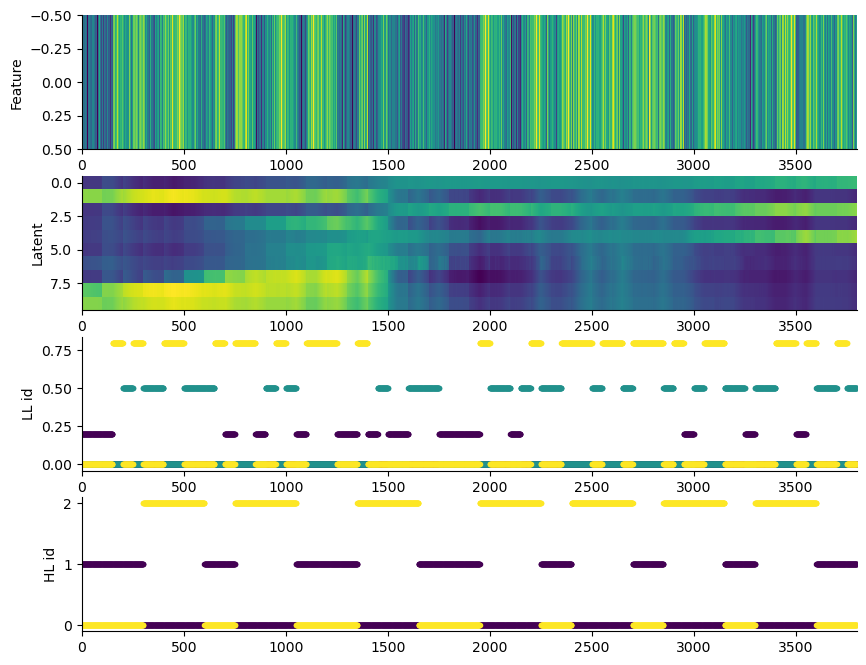

In [19]:
# limit all plots to x1 = 0, x2 = 800
x1, x2 = 0, 3800
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
ax = axes[0]
ax.imshow(ci[x1:x2, :-config.latent_dims[0]].T, aspect='auto', cmap='viridis', interpolation='none')
ax.set_ylabel('Feature')
# ax.set_xlim(x1, x2)
ax = axes[1]
ax.imshow(ci[x1:x2, -config.latent_dims[0]:].T, aspect='auto', cmap='viridis', interpolation='none')
ax.set_ylabel('Latent')
ax = axes[2]

unique_ll = np.unique(ll)
unique_hh = np.unique(hh)

ll_cmap = plt.get_cmap('viridis', len(unique_ll))
hh_cmap = plt.get_cmap('viridis', len(unique_hh))

ll_colors = ll_cmap(np.arange(len(unique_ll)))
hh_colors = hh_cmap(np.arange(len(unique_hh)))

for i, ll_id in enumerate(unique_ll):
    ax.plot(ll_id * (ll[x1:x2] == ll_id), '.',linewidth=1,  label=ll_id, color=ll_colors[i])
ax.set_ylabel('LL id')
# x axis tight
ax.set_xlim(x1, x2)
ax = axes[3]
for i, hh_id in enumerate(unique_hh):
    ax.plot(hh_id * (hh[x1:x2] == hh_id), '.',linewidth=1,  label=hh_id, color=hh_colors[i])
ax.set_ylabel('HL id')
ax.set_xlim(x1, x2)

In [20]:
# from functions_and_utils import plot_tnse_previous_colors
# plot_tnse_previous_colors(logger, config)
# plt.savefig(f'{config.export_path}Massive_training_seq_len{config.seq_len}_tsne.pdf', format='pdf', bbox_inches='tight')


In [21]:
# Increadible. Made a mistake below in how I got the input from combined input log 
# I forgot to reshape the input to a flat vector, and the results 
# were so much more intuitive and I lost the weird curves in the tsne plot
# I need to look into this. I think I bugged inot the right way to give tsne the data
#  

C:\Users\Ali\AppData\Local\Temp\ipykernel_21684\3185893726.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(0, 0, c=ll_cmap(ll_id), label=ll_id, s=7, alpha=0.9)
C:\Users\Ali\AppData\Local\Temp\ipykernel_21684\3185893726.py:67: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(0, 0, c=hh_cmap(hh_id), label=hh_id, s=7, alpha=0.9)


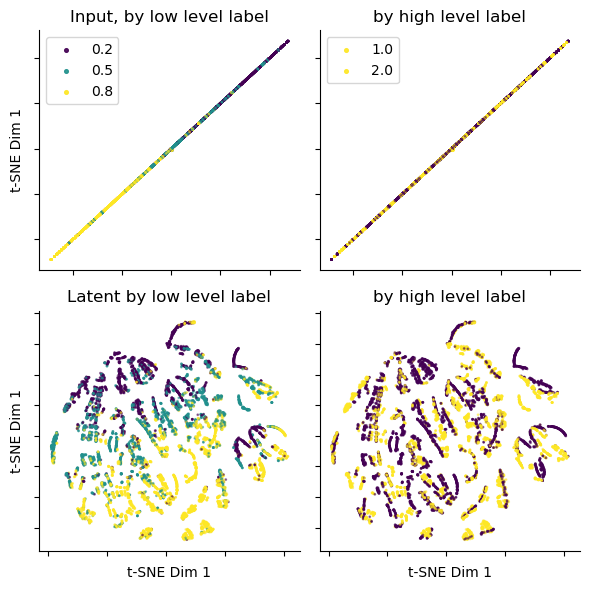

In [25]:
    from sklearn.manifold import TSNE


    ci = np.concatenate(logger.training_batches, axis=0)
    ci = ci.reshape(-1, ci.shape[-1])
    # li = np.concatenate(logger.latent_values, axis=0)
    # li = li.reshape(-1, li.shape[-1])
    # li = ci[:, -config.latent_dims[0]:]  # latent
    li = ci[:, :config.latent_dims[0]]  # latent
    ii = ci[:, :-config.latent_dims[0]]  # latent
    # ii = np.concatenate(logger.inputs, axis=0)
    # ii = ii.reshape(-1, ii.shape[-1])
    ll = np.concatenate(logger.llcids, axis=0)
    ll = ll.reshape(-1, ll.shape[-1])
    hh = np.concatenate(logger.hlcids, axis=0)
    hh = hh.reshape(-1, hh.shape[-1])

    # trying to debug
    ll = np.concatenate(logger.llcids, axis=0)
    ll = ll.reshape(-1,)
    hh = np.concatenate(logger.hlcids, axis=0)
    hh = hh.reshape(-1,)

    # Apply t-SNE
    how_many = 10000
    ll = ll[-how_many:]
    hh = hh[-how_many:]
    dimensionality = ii.shape[-1]
    if dimensionality > 1:
        ii_tsne = TSNE(n_components=2).fit_transform(ii[-how_many:, ])
    else:
        ii_tsne = TSNE(n_components=1).fit_transform(ii[-how_many:, ])
    latent_tsne = TSNE(n_components=2).fit_transform(li[-how_many:, ])

    unique_ll = np.unique(ll)
    ll_cmap = plt.get_cmap('viridis', len(unique_ll))
    ll_colors = ll_cmap(np.arange(len(unique_ll)))

    unique_hh = np.unique(hh)
    hh_cmap = plt.get_cmap('viridis', int(max(unique_hh)))
    hh_colors = hh_cmap(np.arange(len(unique_hh)))

    fig, axes = plt.subplots(2, 2, figsize=(6, 6), dpi=100)
    try:
        ax = axes[0, 0]
        ax.set_title('Input, by low level label')
        for i, ll_id in enumerate(unique_ll):
            # ax.scatter three fake data points to make the legend work
            ax.scatter(0, 0, c=ll_cmap(ll_id), label=ll_id, s=7, alpha=0.9)
            ax.legend()

        if dimensionality ==1:
            ax.scatter(ii_tsne[:, ], ii_tsne[:,], c=ll[:ii_tsne.shape[0]], cmap='viridis', s=1, alpha=0.5)
                # ax.scatter(ii_tsne[ll == ll_id], ii_tsne[ll == ll_id], c=ll_colors[i], label=ll_id, s=3, alpha=0.3)
                # ax.scatter(ii_tsne[ll == ll_id], ii_tsne[ll == ll_id], c=ll_cmap(ll_id),  s=3, alpha=0.3)
    
        else:
            ax.scatter(ii_tsne[:, 0], ii_tsne[:, 1], c=ll[:ii_tsne.shape[0]], cmap='viridis', s=1, alpha=0.5)
        # ax.legend()
        ax.set_xlabel('t-SNE Dim 1')
        ax.set_ylabel('t-SNE Dim 1')

        ax = axes[0, 1]
        ax.set_title('by high level label')
        for i, hh_id in enumerate(unique_hh):
            # ax.scatter three fake data points to make the legend work
            ax.scatter(0, 0, c=hh_cmap(hh_id), label=hh_id, s=7, alpha=0.9)
            ax.legend()

        if dimensionality ==1:
            ax.scatter(ii_tsne[:, ], ii_tsne[:,], c=hh[:ii_tsne.shape[0]], cmap='viridis', s=1, alpha=0.5)
        else:
            ax.scatter(ii_tsne[:, 0], ii_tsne[:, 1], c=hh[:ii_tsne.shape[0]], cmap='viridis', s=1, alpha=0.5)

        ax.legend()
        ax.set_xlabel('t-SNE Dim 1')
        ax.set_ylabel('t-SNE Dim 1')
    except:
        pass
    # Plot t-SNE results for latent
    ax = axes[1, 0]
    ax.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=ll[:latent_tsne.shape[0]], cmap='viridis', s=1, alpha=0.5)
    ax.set_xlabel('t-SNE Dim 1')
    ax.set_ylabel('t-SNE Dim 1')
    ax.set_title('Latent by low level label')

    ax = axes[1, 1]
    ax.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=hh[:latent_tsne.shape[0]], cmap='viridis', s=1, alpha=0.5)
    ax.set_xlabel('t-SNE Dim 1')
    ax.set_ylabel('t-SNE Dim 1')
    ax.set_title('by high level label')

    # label only outer panels and hide inner panels
    for ax in axes.flatten():
        ax.label_outer()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.tight_layout()
    plt.savefig(f'v2_Massive_training_seq_len{config.seq_len}_tsne.pdf', format='pdf', bbox_inches='tight')

In [ ]:
# Below is the original tsne code with the file

In [10]:
from sklearn.manifold import TSNE

# Apply t-SNE
how_many = 10000
ci_tsne = TSNE(n_components=1).fit_transform(ci[-how_many:, :config.input_size])
latent_tsne = TSNE(n_components=2).fit_transform(ci[-how_many:, -config.latent_dims[0]:])

Text(0.5, 1.0, 't-SNE Visualization of latent')

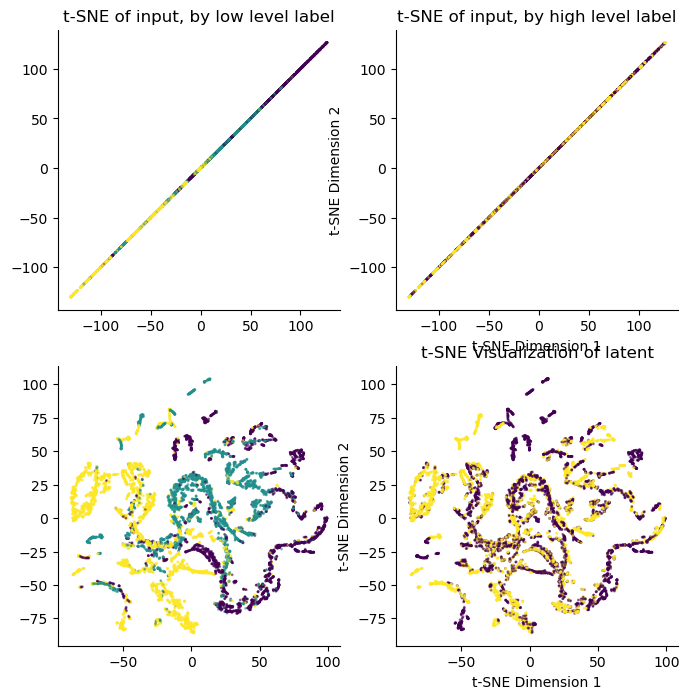

In [ ]:
# Plot t-SNE results
fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=100)
ax = axes[0,0]
ax.set_title('t-SNE of input, by low level label')
ax.scatter(ci_tsne[:, 0], ci_tsne[:, 0], c=ll[:ci_tsne.shape[0]], cmap='viridis', s=1, alpha=0.3)
ax = axes[0,1]
ax.set_title('t-SNE of input, by high level label')
ax.scatter(ci_tsne[:, 0], ci_tsne[:, 0], c=hh[:ci_tsne.shape[0]], cmap='viridis', s=1, alpha=0.3)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
# plt.colorbar(label='LL id')
# Since the space is 1D, plot the values of ci_tsne as a box plot separated by hh values
# ax.boxplot(ci_tsne, positions=hh[:ci_tsne.shape[0]], widths=0.5)
# get the ci_tsne values for each hh value
# ci_tsne_by_hh = [ci_tsne[hh == hh_id][-100:] for hh_id in unique_hh]
# ax.boxplot(ci_tsne_by_hh, positions=unique_hh, widths=0.5, showfliers=True, showmeans=True, meanline=True)
# plot as a scatter plot
# for i, hh_id in enumerate(unique_hh):
#     ax.plot(hh_id * (hh[-300:] == hh_id), ci_tsne[-300:], '.',linewidth=.1,  alpha = 0.1,label=hh_id, color=hh_colors[i])
# ax.legend()


# Plot t-SNE results for latent
ax = axes[1,0]
ax.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=ll[:latent_tsne.shape[0]], cmap='viridis', s=1, alpha=0.5)
ax = axes[1,1]
ax.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=hh[:latent_tsne.shape[0]], cmap='viridis', s=1, alpha=0.5)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_title('t-SNE Visualization of latent')
# ax.colorbar(label='LL id')

In [ ]:
# try:

for bi, batch in enumerate(dataloader):
    inputs, batch_llcids, batch_hlcids = batch
    inputs = inputs.to(config.device)
    break

demo_latent_plots(model, inputs, 'latent_optimization_context_task')
# except:
print('failed to create the gif')

C:\Users\Ali\AppData\Local\Temp\ipykernel_8728\1914924314.py:294: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(2, 1, figsize=(6, 4))
C:\Users\Ali\AppData\Local\Temp\ipykernel_8728\1914924314.py:313: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(plot) for plot in plots]


failed to create the gif


In [ ]:
ci.shape

(9971, 11)